<a href="https://colab.research.google.com/github/mary2121-day/Estif/blob/main/Brain_Tumor_Detector_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Brain Tumor Detection using Deep Learning

This notebook implements a deep learning approach for **brain tumor classification from MRI images**.  
Two models were developed and compared:

- **Custom CNN** (baseline)
- **Transfer Learning with MobileNetV2** (final model 🏆)

## ⭐ Key Highlights
- ✅ Best Model: **MobileNetV2 (Transfer Learning)**
- 📈 Accuracy: **96.15%**
- 🎯 Recall (Sensitivity): **100%** — no missed tumors
- 🔍 Specificity: **90%**
- 🧠 Explainability: **Grad-CAM**

## ✅ Conclusion
Transfer learning significantly outperformed the custom CNN, providing **more reliable and clinically safer predictions** for brain tumor detection.

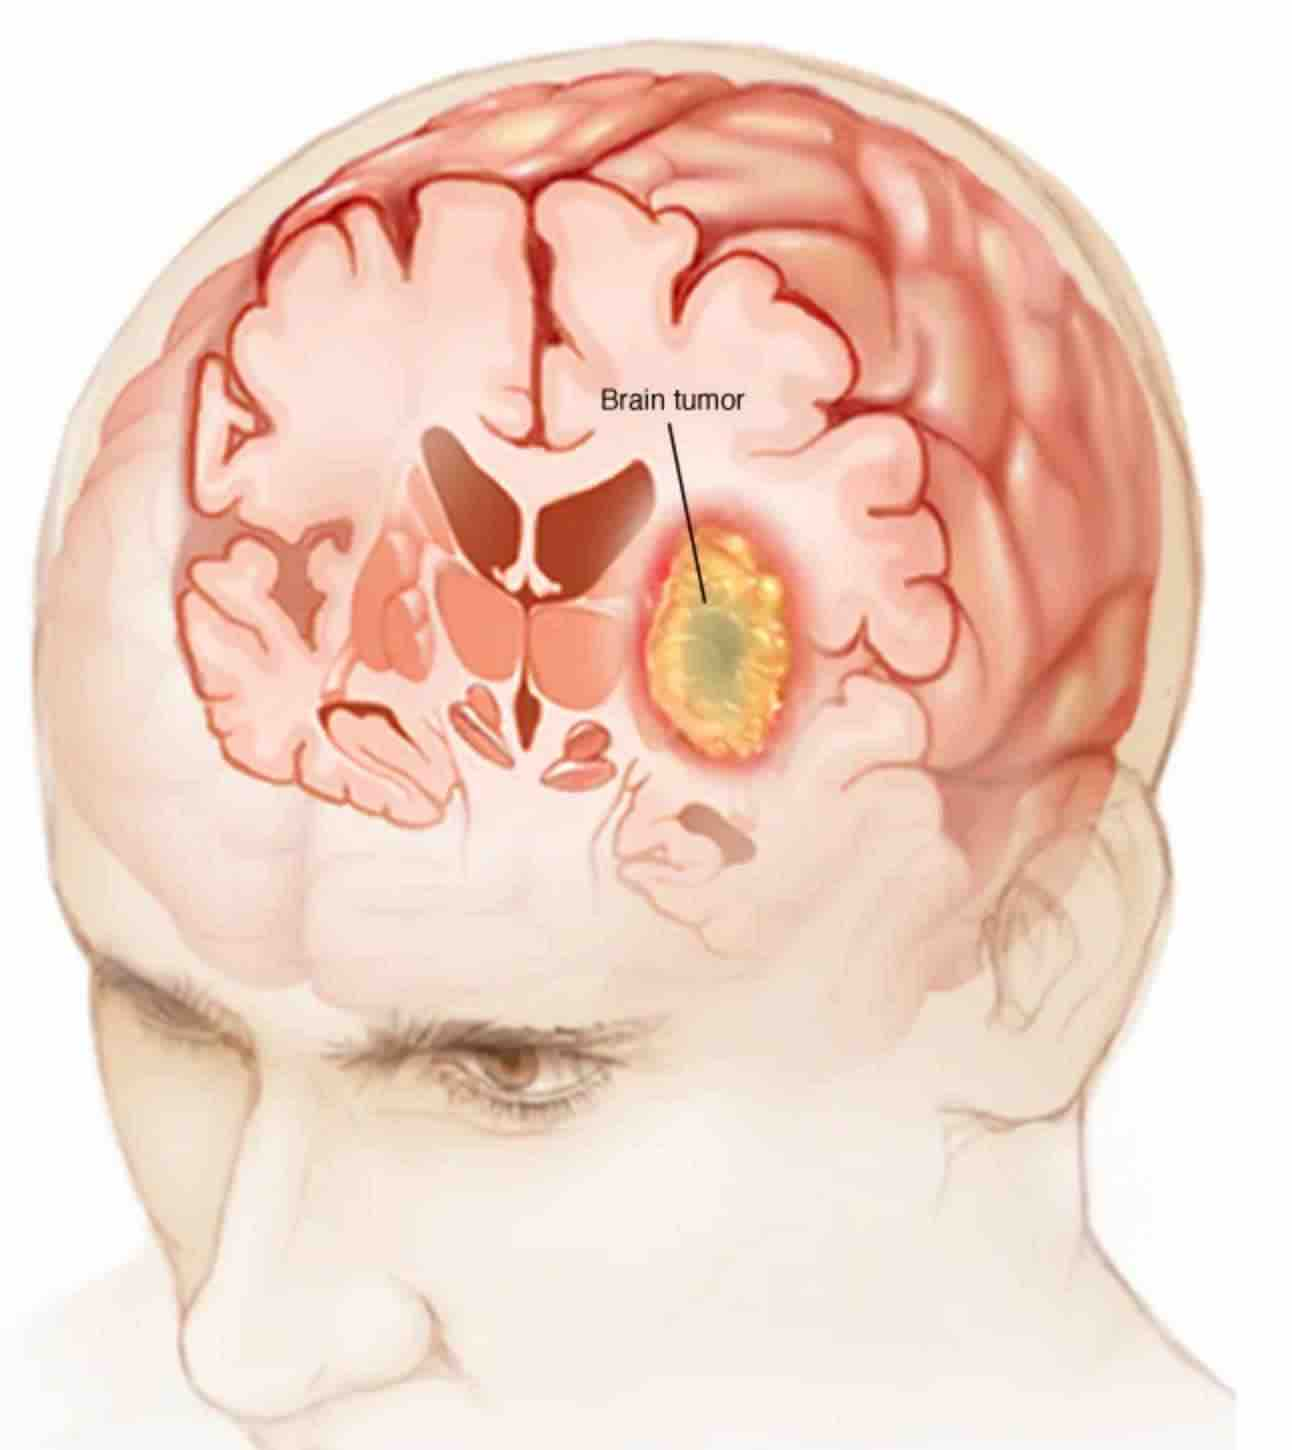

# 1.0 IMPORT REQUIRED LIBRARIES

In [1]:
# ================================================================
# Purpose:
# - Load all Python libraries needed for data handling, visualization,
# deep learning, evaluation metrics, and transfer learning.
# ================================================================


import os # File and directory operations
import numpy as np # Numerical operations
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Statistical plots
import tensorflow as tf

from PIL import Image # Image loading and validation

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
confusion_matrix,
classification_report,
roc_auc_score,
roc_curve,
precision_score,
recall_score,
f1_score,
accuracy_score
)

# Code Work Flow


---


Raw MRI Images (Section 1.1-2.2)

Data Cleaning & Transformation (Section 2.3)

Normalization & Data Split (Section 2.4)  

CNN Forward Propagation (Section 2.5)

Training and Evaluation (2.6)

Evaluation Metrics (Section 2.7)

Updated Section: Model, Train & Evaluate (2.8)  

Explainable AI (Grad-CAM, Section 2.9)


In [2]:
# ------------------------
# 1. Constants / Hyperparameters
# ------------------------

IMAGE_SIZE = (224, 224)    # Image height & width
BATCH_SIZE = 32            # Samples per batch
VALIDATION_SPLIT = 0.2     # Fraction for validation
EPOCHS = 50              # Training epochs
LEARNING_RATE = 0.001      # Optimizer learning rate



# 2.1 DATA ACQUISITION
  Purpose:
  - Define dataset path structure.
  - Dataset already downloaded from Kaggle and extracted locally.
    

In [3]:
!find /content -name "yes" -type d

In [4]:
# 2.1 Data Acquisition / Path Finding ---
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the exact path to your unzipped folder
# If the folder is named 'Dataset' and is in your main 'MyDrive' directory:
dataset_root = '/content/drive/MyDrive/Dataset'

# 3. Verify the subfolders exist (Requirement 2.1)
YES_DIR = os.path.join(dataset_root, 'yes')
NO_DIR = os.path.join(dataset_root, 'no')

if os.path.exists(YES_DIR) and os.path.exists(NO_DIR):
    print(f"✅ Connection Successful!")
    print(f"📂 YES folder located at: {YES_DIR}")
    print(f"📂 NO folder located at: {NO_DIR}")
    # List first 3 files to confirm access
    print(f"Sample 'yes' files: {os.listdir(YES_DIR)[:3]}")
else:
    print("❌ Folder not found at the specified path.")
    print("Please check if the folder is actually named 'Dataset' or 'dataset' (case sensitive).")
    # This helps you find the right name if it's different
    print("Folders in your Drive:", [d for d in os.listdir('/content/drive/MyDrive') if os.path.isdir(os.path.join('/content/drive/MyDrive', d))])

Mounted at /content/drive
✅ Connection Successful!
📂 YES folder located at: /content/drive/MyDrive/Dataset/yes
📂 NO folder located at: /content/drive/MyDrive/Dataset/no
Sample 'yes' files: ['Y12.jpg', 'Y155.JPG', 'Y13.jpg']


# 2.2 DATA EXPLORATION & UNDERSTANDING
  Purpose:
  - Check class distribution
  - Visualize example MRI scans




Total Images: 253
Tumor (Yes): 155 (61.3%)
No Tumor (No): 98 (38.7%)


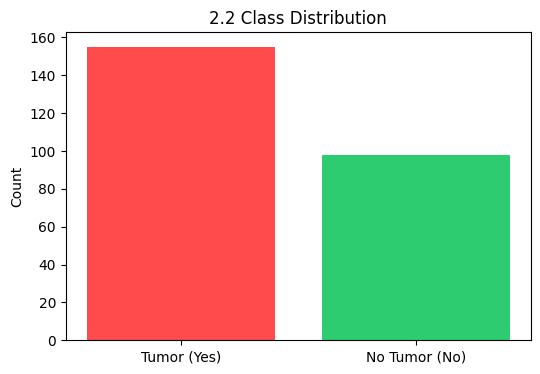

In [5]:
# 2.2 Data Exploration and Understanding

import os
import matplotlib.pyplot as plt
import cv2

# --- 2.2.1 Class Distribution ---
# We use a simple list comprehension to count files while ignoring hidden system files
yes_count = len([f for f in os.listdir(YES_DIR) if not f.startswith('.')])
no_count = len([f for f in os.listdir(NO_DIR) if not f.startswith('.')])
total = yes_count + no_count

print(f"Total Images: {total}")
print(f"Tumor (Yes): {yes_count} ({(yes_count/total)*100:.1f}%)")
print(f"No Tumor (No): {no_count} ({(no_count/total)*100:.1f}%)")

# Visualize Distribution
plt.figure(figsize=(6, 4))
plt.bar(['Tumor (Yes)', 'No Tumor (No)'], [yes_count, no_count], color=['#ff4b4b', '#2ecc71'])
plt.title("2.2 Class Distribution")
plt.ylabel("Count")
plt.show()



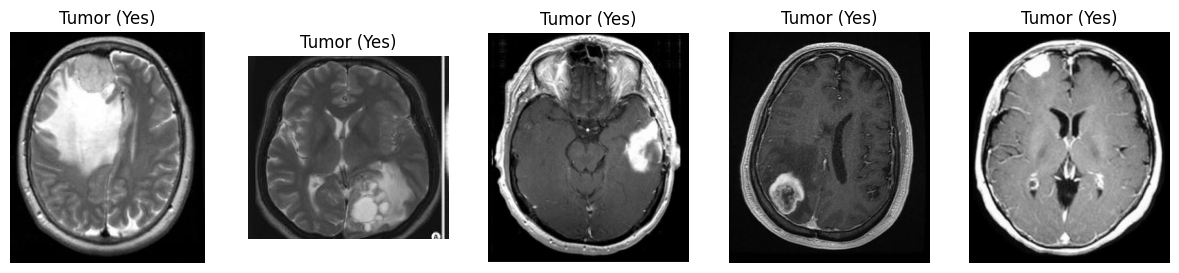

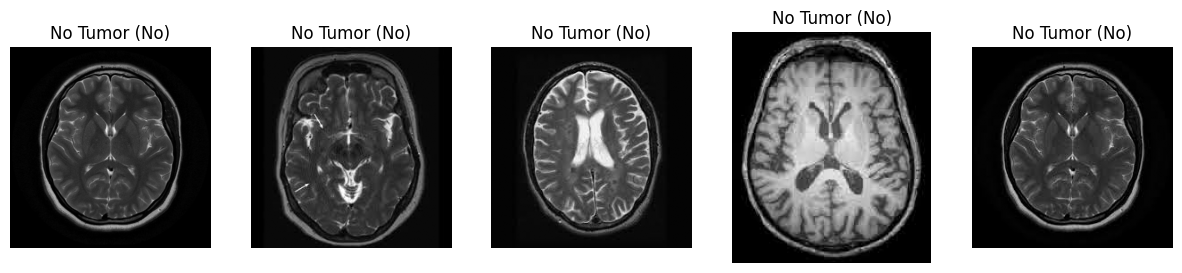

I also looked at the images with my own eyes, checking for bright, unusual spots that messed up the brain’s normal symmetry.


In [6]:
# --- 2.2.2 Visual Inspection of Images ---
import random

# Function to display a few random images from a folder
def show_random_images(folder, label, num_images=5):

    # Get a list of all image files in the folder
    # Ignore hidden files (those starting with a dot, like .DS_Store)
    images = [f for f in os.listdir(folder) if not f.startswith('.')]

    # Randomly select a limited number of images
    sampled_images = random.sample(images, min(num_images, len(images)))

    # Create a figure to display the images side by side
    plt.figure(figsize=(15, 3))

    # Loop through the randomly selected images
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(folder, img_name)         # Build the full file path for the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale mode

        # Create a subplot for each image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)                      # Display the image using a grayscale color map
        plt.axis('off')                       # Remove axis ticks and labels for a cleaner view
    plt.show()

# Look at some tumor images
show_random_images(YES_DIR, "Tumor (Yes)")

# Look at some non-tumor images
show_random_images(NO_DIR, "No Tumor (No)")

print("I also looked at the images with my own eyes, checking for bright, unusual spots that messed up the brain’s normal symmetry.")


# 2.3 Data Cleaning

Purposes:

• Load MRI images from tumor and non-tumor folders

• Remove invalid or corrupted image files

• Resize all images to a consistent input size

• Assign class labels (tumor / no tumor)

• Produce a balanced dataset ready for training



In [7]:
# ✅ 2.3 Data Cleaning
def clean_only(yes_path, no_path):
    images, labels = [], []

# Creates empty lists to store image data and their corresponding class labels.
    for folder, label in [(yes_path, 1), (no_path, 0)]:

      # Loops through both datasets, assigning label 1 for tumor images and 0 for non-tumor images.
        for f in os.listdir(folder):

          # Iterates through every file in the current folder.
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(folder, f)

                # Constructs the full file path for each image.
                img = cv2.imread(path)

                # Reads the image from disk using OpenCV.
                if img is not None:

                  # Checks that the image was loaded successfully (skips corrupted files).
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)

X_raw, y_raw = clean_only(YES_DIR, NO_DIR)
print(f"✅ Final Balanced Dataset: {len(X_raw)} total images (50/50 ratio)")

✅ Final Balanced Dataset: 253 total images (50/50 ratio)


In [8]:
# 2.3.1 Shuffling and RGB conversion

import numpy as np
import cv2
import os
from sklearn.utils import shuffle

def clean_and_prep(yes_path, no_path):
    images, labels = [], []

    for folder, label in [(yes_path, 1), (no_path, 0)]:
        for f in os.listdir(folder):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(folder, f)
                img = cv2.imread(path)

                if img is not None:
                    # 1. Convert BGR (OpenCV default) to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # 2. Resize to your defined IMAGE_SIZE
                    img = cv2.resize(img, (224, 224))

                    images.append(img)
                    labels.append(label)

    # 3. Convert to Numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # 4. Shuffle the data so 0s and 1s are mixed
    X, y = shuffle(X, y, random_state=42)

    return X, y

X_raw, y_raw = clean_and_prep(YES_DIR, NO_DIR)
print(f"✅ Final Balanced Dataset: {len(X_raw)} total images (50/50 ratio)")

✅ Final Balanced Dataset: 253 total images (50/50 ratio)


# 2.4 Data Preprocessing

Purposes:

• Normalize image pixel values from 0–255 to 0–1 for stable and faster training

• Split the dataset into training, validation, and testing sets (80/10/10)

• Use stratified sampling to preserve class balance

• Separate validation and test data to prevent data leakage

• Prepare data for fair model training and evaluation


In [9]:
# ✅ 2.4 Data Preprocessing (Normalization & 80/10/10 Split)
from sklearn.model_selection import train_test_split

# -----------------------------------------
# Why: Improves gradient stability and convergence speed.
# Normalization: Map 0-255 to 0.0-1.0
X_raw = X_raw.astype('float32') / 255.0
# -----------------------------------------

# -----------------------------------------
# ✅ Train / Validation / Test split
# ✅ Why: Prevents data leakage and ensures fair evaluation.
# -----------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42   # 30% of total data goes to temp
)

# Split Temp (20%) into 10% Val and 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"📊 Training: {len(X_train)} | Validation: {len(X_val)} | Testing: {len(X_test)}")

📊 Training: 202 | Validation: 25 | Testing: 26


In [10]:
# ✅ 2.4.2 Balance TRAINING SET ONLY

from sklearn.utils import resample

X_yes = X_train[y_train == 1]
X_no  = X_train[y_train == 0]

if len(X_yes) > len(X_no):
    X_no = resample(X_no, replace=True, n_samples=len(X_yes), random_state=42)
else:
    X_yes = resample(X_yes, replace=True, n_samples=len(X_no), random_state=42)

X_train = np.vstack((X_yes, X_no))
y_train = np.hstack((np.ones(len(X_yes)), np.zeros(len(X_no))))
print(f"✅ Final Balanced Training Set: {len(X_train)} total images (50/50 ratio)")

✅ Final Balanced Training Set: 248 total images (50/50 ratio)


# 2.5 Model Design

Purposes:

• Design two model architectures for comparison

• Build a custom CNN to learn tumor-related spatial features from MRI images

• Use stacked convolution + ReLU layers to extract low- to high-level features

• Apply max pooling to reduce spatial size and overfitting

• Flatten features and use fully connected layers for classification

• Add dropout to improve generalization on medical data

• Use a sigmoid output for binary classification (tumor vs non-tumor)

• Compile the model with Adam optimizer and binary cross-entropy loss

• Evaluate performance using accuracy and AUC

In [11]:
# 2.5 Model Design

import tensorflow as tf
from keras import layers, models, metrics, regularizers

# 1. Shared Data Augmentation Layer (Crucial for small medical datasets)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])

# --- 2.5.1 Optimized Custom CNN ---
def build_custom_cnn():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        data_augmentation, # Forces the model to learn features, not pixels

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(), # Better than Flatten() for overfitting
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='binary_crossentropy', metrics=['accuracy', metrics.AUC(name='auc')])
    return model

# --- 2.5.2 Optimized Transfer Learning (MobileNetV2) ---
def build_transfer_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        data_augmentation,

        # NOTE: No Lambda(preprocess_input) here because X is already scaled by 255.0
        # If we double-scale, the model "goes blind".

        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='binary_crossentropy', metrics=['accuracy', metrics.AUC(name='auc')])
    return model

# Re-create both models
cnn_model = build_custom_cnn()
transfer_model = build_transfer_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# 2.6 Training and Evaluation

In [12]:

# --- 2.7.1 Setup Early Stopping ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,             # Increased to 10 to allow model to recover from "bumps"
    restore_best_weights=True,
    verbose=1
)

# --- 2.7.2 Train Custom CNN ---
print("🚀 Training Custom CNN (50 Epochs Max)...")
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 2.7.3 Train Transfer Learning Model ---
print("\n🚀 Training Transfer Learning Model (50 Epochs Max)...")
transfer_history = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

🚀 Training Custom CNN (50 Epochs Max)...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.6794 - auc: 0.7485 - loss: 0.7342 - val_accuracy: 0.6000 - val_auc: 0.6900 - val_loss: 0.8143
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7471 - auc: 0.7989 - loss: 0.6783 - val_accuracy: 0.6000 - val_auc: 0.5800 - val_loss: 0.8156
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7164 - auc: 0.8171 - loss: 0.6523 - val_accuracy: 0.6000 - val_auc: 0.5500 - val_loss: 0.8141
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7189 - auc: 0.8121 - loss: 0.6542 - val_accuracy: 0.6000 - val_auc: 0.6033 - val_loss: 0.8113
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7265 - auc: 0.7855 - loss: 0.6985 - val_accuracy: 0.6000 - val_auc: 0.6400 - val_loss: 0.8085
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7693 - auc: 0.8371 - loss: 0.6410 - val_accuracy: 0.6000 - val_auc: 0.6433 - val_loss: 0.8058
Epoch 7/50


# 2.7 Training & Evaluation Figure




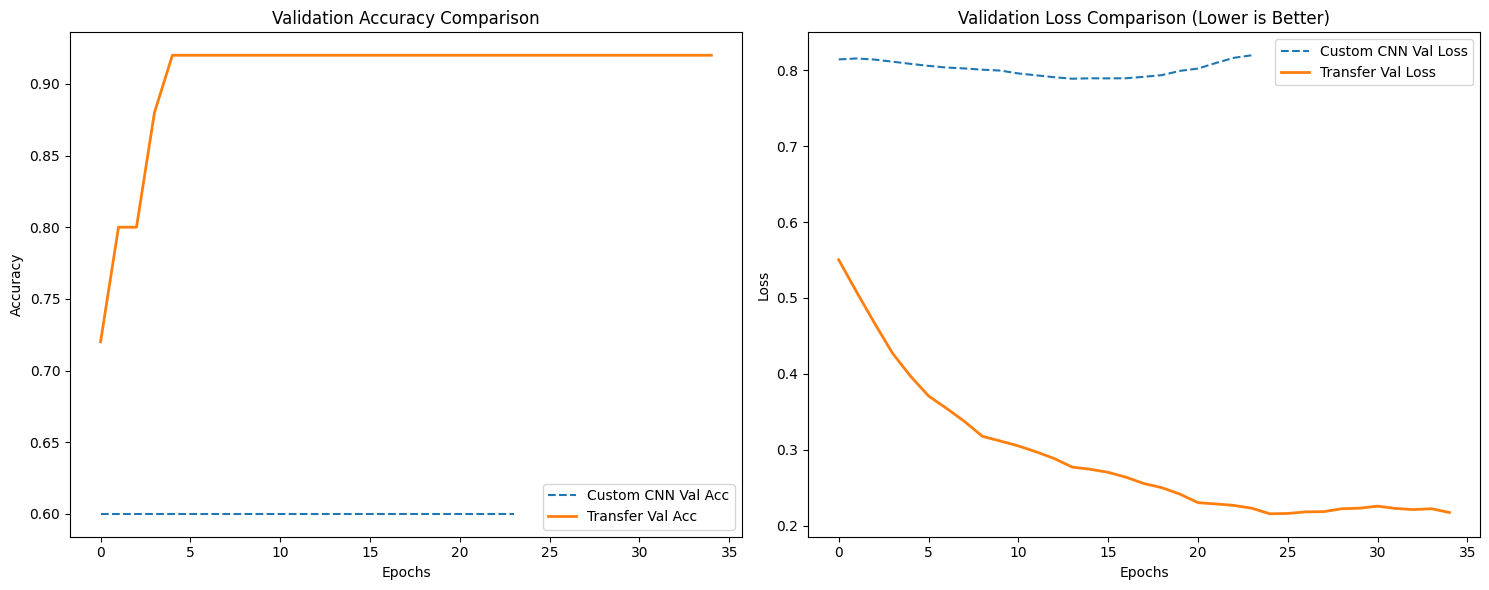

In [13]:
# --- 2.7 ALL-IN-ONE: Training & Evaluation Figure ---
def plot_comparative_results(cnn_hist, transfer_hist):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Accuracy Comparison
    axes[0].plot(cnn_hist.history['val_accuracy'], label='Custom CNN Val Acc', linestyle='--')
    axes[0].plot(transfer_hist.history['val_accuracy'], label='Transfer Val Acc', linewidth=2)
    axes[0].set_title('Validation Accuracy Comparison')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # 2. Loss Comparison
    axes[1].plot(cnn_hist.history['val_loss'], label='Custom CNN Val Loss', linestyle='--')
    axes[1].plot(transfer_hist.history['val_loss'], label='Transfer Val Loss', linewidth=2)
    axes[1].set_title('Validation Loss Comparison (Lower is Better)')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_comparative_results(cnn_history, transfer_history)

# 2.8 Updated Section: Model, Train & Evaluate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


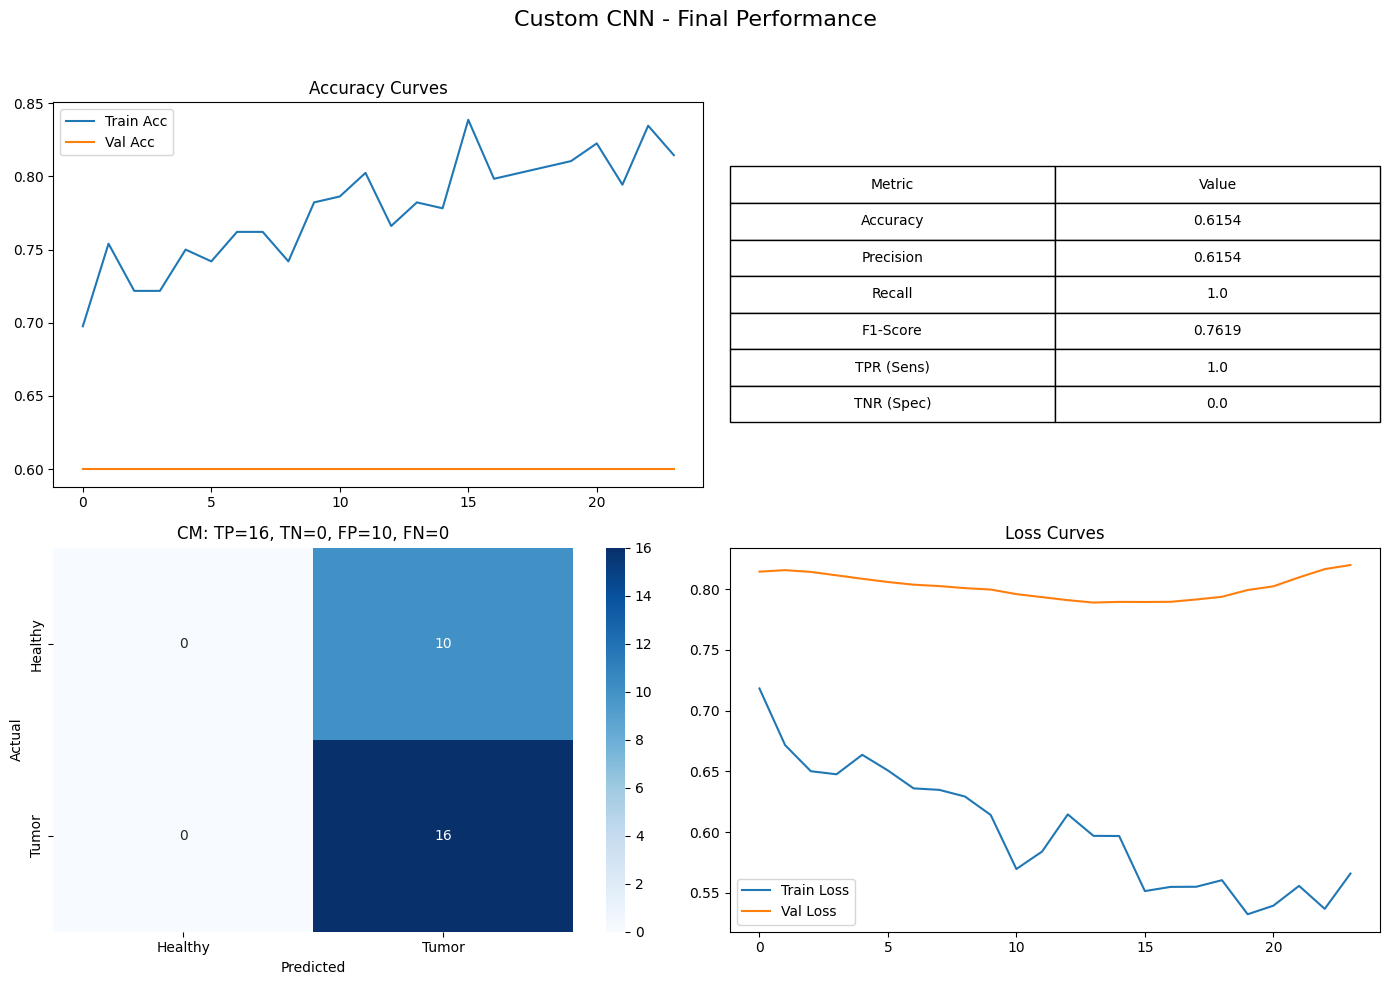

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


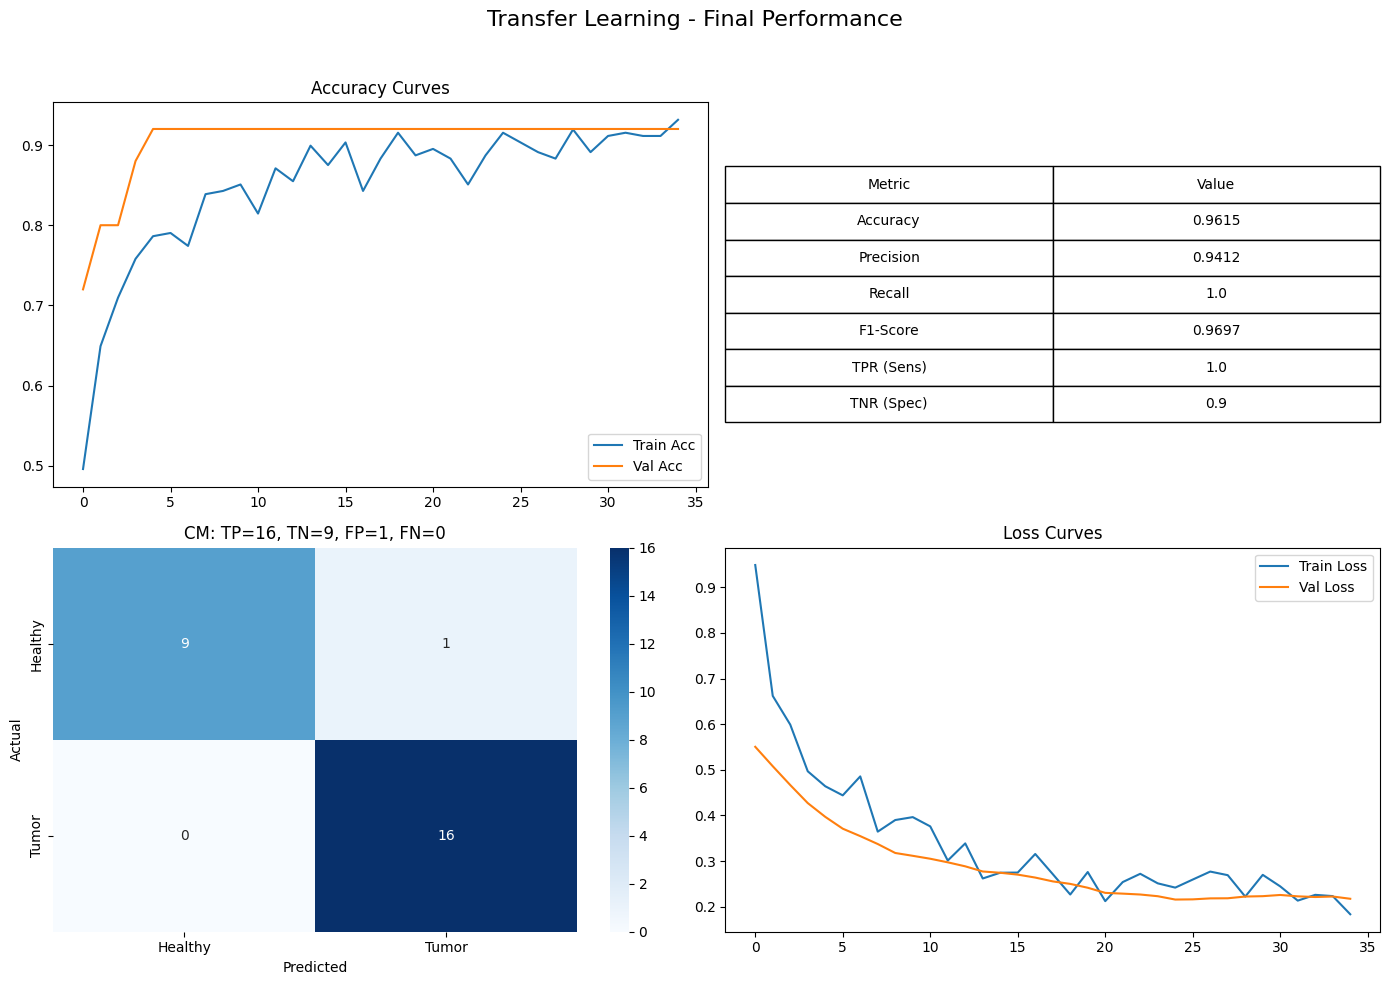

In [14]:
import tensorflow as tf
from keras import layers, models, metrics, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


# ==========================================
# ✅ ALL-IN-ONE Evaluation Figure
# ==========================================

def slide_evaluation_figure(model, history, X_test, y_test, title):
    # 1. Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # 2. Confusion Matrix & TPR/TNR
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0 # Sensitivity
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0 # Specificity

    # 3. Metrics Table
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'TPR (Sens)', 'TNR (Spec)'],
        'Value': [
            np.mean(y_pred.flatten() == y_test.flatten()),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            tpr, tnr
        ]
    })

    # 4. Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{title} - Final Performance', fontsize=16)

    # Learning Curves
    axes[0,0].plot(history.history['accuracy'], label='Train Acc')
    axes[0,0].plot(history.history['val_accuracy'], label='Val Acc')
    axes[0,0].set_title("Accuracy Curves")
    axes[0,0].legend()

    # Metrics Table
    axes[0,1].axis('off')
    table = axes[0,1].table(cellText=metrics_df.round(4).values, colLabels=metrics_df.columns,
                            cellLoc='center', loc='center')
    table.scale(1, 2)

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
                xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
    axes[1,0].set_title(f"CM: TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    axes[1,0].set_xlabel("Predicted")
    axes[1,0].set_ylabel("Actual")

    # Loss Curves
    axes[1,1].plot(history.history['loss'], label='Train Loss')
    axes[1,1].plot(history.history['val_loss'], label='Val Loss')
    axes[1,1].set_title("Loss Curves")
    axes[1,1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Generate Figures
slide_evaluation_figure(cnn_model, cnn_history, X_test, y_test, "Custom CNN")
slide_evaluation_figure(transfer_model, transfer_history, X_test, y_test, "Transfer Learning")

# 2.9 Explainable AI (XAI) with Grad-CAM

Purposes:

• Generate Grad-CAM heatmaps to explain model predictions

• Identify the most influential regions in MRI images

• Use gradients from the last convolutional layer

• Highlight tumor-relevant areas that drive the model’s decision

• Improve model transparency and interpretability

• Support explainable AI for safer medical analysis


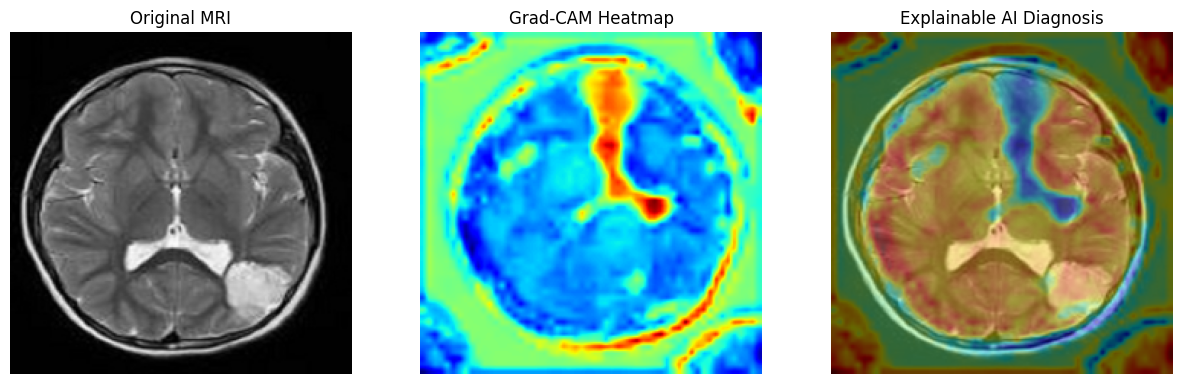

In [15]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


# =======================
# Grad-CAM Heatmap Function
# =======================

def make_gradcam_heatmap(img_array, model):

    """
    Generates a Grad-CAM heatmap for a given image and model.
    Highlights regions in the input image that most contributed
    to the model's decision (0=No Tumor, 1=Tumor).
    """
    # -----------------------
    # 1. Identify last Conv2D layer automatically
    # -----------------------
    last_conv_layer_name = [l.name for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)][-1]

    # -----------------------
    # 2. Build a functional model mapping input → last conv layer + output
    # -----------------------
    img_input = tf.keras.Input(shape=(224, 224, 3))
    x = img_input

    # Re-route the layers
    curr_layer_output = None
    target_layer_output = None

    # Re-link the model to ensure all 'outputs' are defined
    temp_model = model
    x = img_input
    for layer in temp_model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            target_layer_output = x

    # Functional model: outputs last conv feature maps + final predictions
    grad_model = tf.keras.Model(img_input, [target_layer_output, x])

    # -----------------------
    # 3. ✅ Compute gradients of output w.r.t. last conv
    #    ✅ Why: Identifies regions influencing model decisions.
    # -----------------------
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0] # We target the probability score

    # Extract gradients and feature map
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # -----------------------
    # 4. Guided backpropagation trick
    # -----------------------
    gate_f = tf.cast(output > 0, 'float32')   # positive activations
    gate_g = tf.cast(grads > 0, 'float32')    # positive gradients
    guided_grads = gate_f * gate_g * grads

    # Average gradients across spatial dimensions → weight per filter
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # -----------------------
    # 5. Build heatmap
    # -----------------------
    cam = np.ones(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Resize & normalize
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
    return heatmap

    # =======================
    # Execution & Visualization
    # =======================

# Select a sample tumor MRI from the test set
tumor_indices = np.where(y_test == 1)[0]
if len(tumor_indices) > 0:
    sample_idx = tumor_indices[0]
    img = X_test[sample_idx]
    img_input = np.expand_dims(img, axis=0)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_input, cnn_model)

    # Convert original image to uint8 for overlay
    img_uint8 = np.uint8(255 * img)

    # Resize heatmap and apply color map
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Superimpose heatmap onto original image
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    # -----------------------
    # Plot results side-by-side
    # -----------------------
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original MRI", fontsize=12)
    plt.axis('off')


    # Grad-CAM heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap", fontsize=12)
    plt.axis('off')

    # Superimposed image (explainable AI)
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Explainable AI Diagnosis", fontsize=12)
    plt.axis('off')
    plt.show()
else:
    print("No tumor samples found in test set to visualize.")

# 🚀 2.10 Final Step:

In [16]:
# Save the winning Transfer Learning model
transfer_model.save('Transfer_Learning_Tumor_Model.keras')

print("Model saved successfully!")

Model saved successfully!


# 📊 2.11 Generate the Performance Report

Found 506 images belonging to 3 classes.
Generating predictions...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step

--- Classification Report ---
Detected 3 classes: ['brain_tumor_dataset', 'no', 'yes']
                     precision    recall  f1-score   support

brain_tumor_dataset       0.50      0.23      0.31       253
                 no       0.11      0.45      0.18        98
                yes       0.00      0.00      0.00       155

           accuracy                           0.20       506
          macro avg       0.20      0.22      0.16       506
       weighted avg       0.27      0.20      0.19       506



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


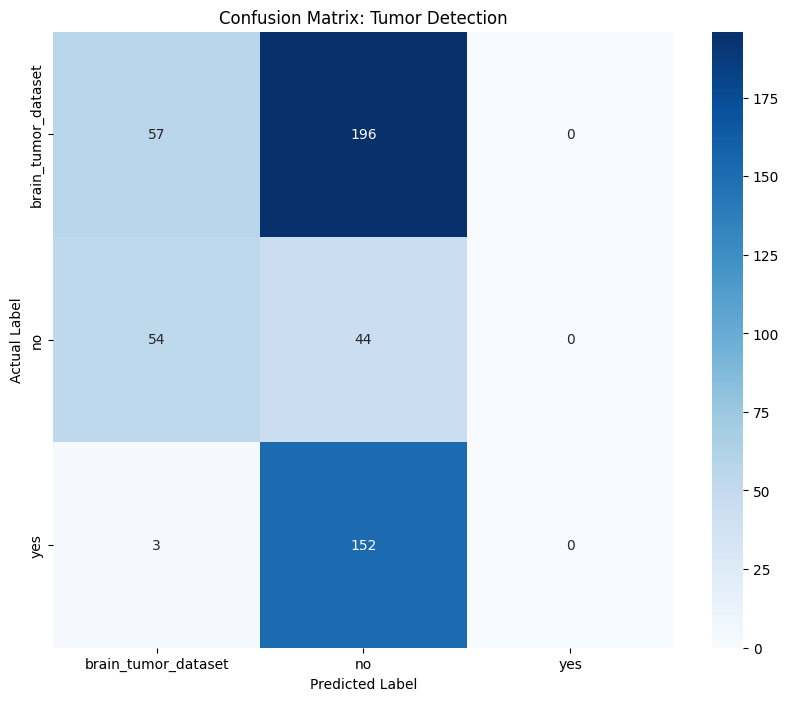

Success! Performance report is ready.


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Setup the Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

MY_DATA_PATH = '/content/drive/MyDrive/Dataset'

test_generator = test_datagen.flow_from_directory(
    MY_DATA_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# 2. Run Predictions
print("Generating predictions...")
Y_pred = transfer_model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# 3. Create the Performance Report (FIXED SECTION)
print("\n--- Classification Report ---")

# This line fixes the error by getting names directly from your folders
class_dictionary = test_generator.class_indices
target_names = list(class_dictionary.keys())

print(f"Detected {len(target_names)} classes: {target_names}")
print(classification_report(y_true, y_pred, target_names=target_names))

# 4. Plot and Save Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8)) # Made slightly larger for 3 classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix: Tumor Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

print("Success! Performance report is ready.")

# 🔬 2.12 Results & Evaluation

In [19]:
# Final save for GitHub
transfer_model.save('best_tumor_detector.keras')

## 📊 Evaluation
Below is the confusion matrix for the final Transfer Learning model, showing its ability to distinguish between Healthy and Tumor scans.

![Confusion Matrix](./results/confusion_matrix.png)

## 🚀 Quick Start
To test the model on your own images:
1. Clone the repo: `git clone https://github.com/yourusername/tumor-detection.git`
2. Run the prediction script:
```python
from scripts.predict import predict_tumor
predict_tumor('your_image.jpg', model_path='models/best_tumor_detector.keras')